<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/04_transfer_learning_in_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** Transfer learning**, in other words, taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

Can leverage an existing neural network architecture proven to work on problems similar to our own.

Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

#Downloading and becoming one with the data

In [8]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-04-18 13:02:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  21.6MB/s    in 8.5s    

2024-04-18 13:03:04 (18.9 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [9]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")



There are 2 directories and 0 images in 10_food_classes_10_percent.
There are 10 directories and 0 images in 10_food_classes_10_percent/train.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza.
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice.
There are

#Creating data loaders

In [10]:
#Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")
print("Testing images:")
test_data_10_percent=test_datagen.flow_from_directory(test_dir,
                                                      target_size=IMAGE_SHAPE,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


#Setting up callbacks

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

**Experiment tracking with TensorBoard** - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.

**Model checkpointing **- save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.

**Early stopping **- leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [11]:
# Create tensorboard callback

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to:{log_dir}")
  return tensorboard_callback

# Creating models using TensorFlow Hub
we're going to use two models from TensorFlow Hub:

ResNetV2 - a state of the art computer vision model architecture from 2016.

EfficientNet - a state of the art computer vision architecture from 2019.

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [13]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"


In [14]:
def create_model(model_url,num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer=hub.KerasLayer(model_url,
                                         trainable=False, # freeze the underlying patterns
                                         name="feature_extractor_layer",
                                         input_shape=IMAGE_SHAPE+(3,))
  #Create the model
  model=tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation='softmax',name='output_layer')
  ])

  return model


In [15]:
#Create the resnet model
resnet_model=create_model(resnet_url,num_classes=train_data_10_percent.num_classes)

#Compile

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
#Fit the model
resnet_history=resnet_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data_10_percent,
                                validation_steps=len(test_data_10_percent),
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                       experiment_name="restnet50V2")])

Saving TensorBoard log files to:tensorflow_hub/restnet50V2/20240417-142824
Epoch 1/5
24/24 [==============================] - 23s 598ms/step - loss: 1.9281 - accuracy: 0.3680 - val_loss: 1.2080 - val_accuracy: 0.6060
Epoch 2/5
24/24 [==============================] - 11s 449ms/step - loss: 0.8880 - accuracy: 0.7293 - val_loss: 0.8615 - val_accuracy: 0.7200
Epoch 3/5
24/24 [==============================] - 13s 546ms/step - loss: 0.6260 - accuracy: 0.8307 - val_loss: 0.7602 - val_accuracy: 0.7560
Epoch 4/5
24/24 [==============================] - 11s 459ms/step - loss: 0.4780 - accuracy: 0.8747 - val_loss: 0.7051 - val_accuracy: 0.7664
Epoch 5/5
24/24 [==============================] - 13s 548ms/step - loss: 0.3832 - accuracy: 0.9080 - val_loss: 0.6735 - val_accuracy: 0.7788


In [ ]:
resnet_history.history

{'loss': [1.9281460046768188,
  0.888028085231781,
  0.6260147094726562,
  0.47799351811408997,
  0.38321810960769653],
 'accuracy': [0.36800000071525574,
  0.7293333411216736,
  0.8306666612625122,
  0.874666690826416,
  0.9079999923706055],
 'val_loss': [1.2080341577529907,
  0.8615144491195679,
  0.7602208256721497,
  0.7051241993904114,
  0.6734884977340698],
 'val_accuracy': [0.6060000061988831,
  0.7200000286102295,
  0.7559999823570251,
  0.7663999795913696,
  0.7788000106811523]}

In [16]:
#Plot the loss curves
import matplotlib.pyplot as plt


def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss=history.history["loss"]
  val_loss=history.history['val_loss']

  accuracy=history.history["accuracy"]
  val_accuracy=history.history['val_accuracy']

  epochs=range(len(history.history['loss']))

  #Plot loss

  plt.plot(epochs,loss,label='training_loss')
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title('Loss')
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();




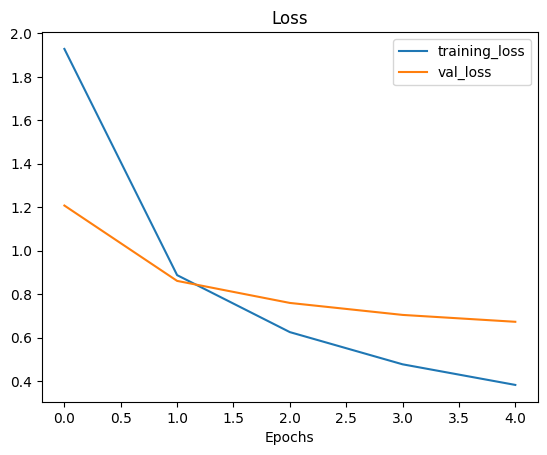

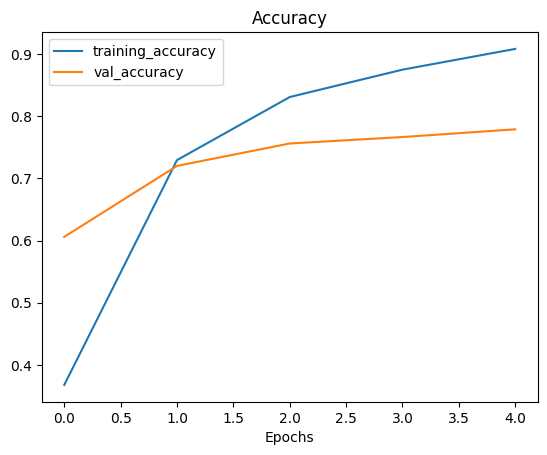

In [ ]:
plot_loss_curves(resnet_history)

In [17]:
train_data_10_percent.num_classes

10

In [18]:
#Create the efficientnet model
efficientnet_model=create_model(efficientnet_url,num_classes=train_data_10_percent.num_classes)

#Complile the model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [20]:
#Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to:tensorflow_hub/efficientnetB0/20240418-131255
Epoch 1/5
24/24 [==============================] - 14s 543ms/step - loss: 1.0479 - accuracy: 0.7920 - val_loss: 0.8394 - val_accuracy: 0.8292
Epoch 2/5
24/24 [==============================] - 12s 494ms/step - loss: 0.7401 - accuracy: 0.8507 - val_loss: 0.6760 - val_accuracy: 0.8536
Epoch 3/5
24/24 [==============================] - 11s 458ms/step - loss: 0.5923 - accuracy: 0.8773 - val_loss: 0.5929 - val_accuracy: 0.8640
Epoch 4/5
24/24 [==============================] - 11s 468ms/step - loss: 0.5019 - accuracy: 0.9027 - val_loss: 0.5421 - val_accuracy: 0.8684
Epoch 5/5
24/24 [==============================] - 11s 483ms/step - loss: 0.4372 - accuracy: 0.9093 - val_loss: 0.5111 - val_accuracy: 0.8712


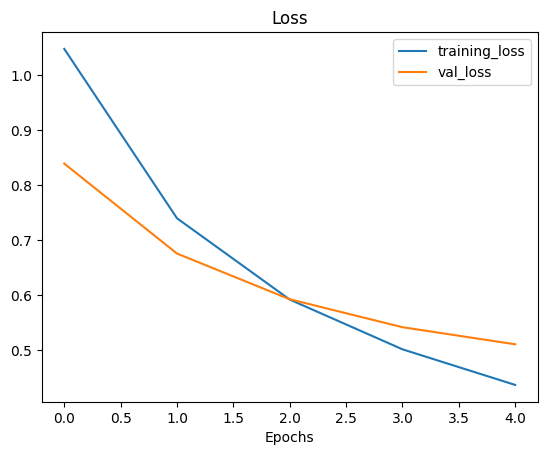

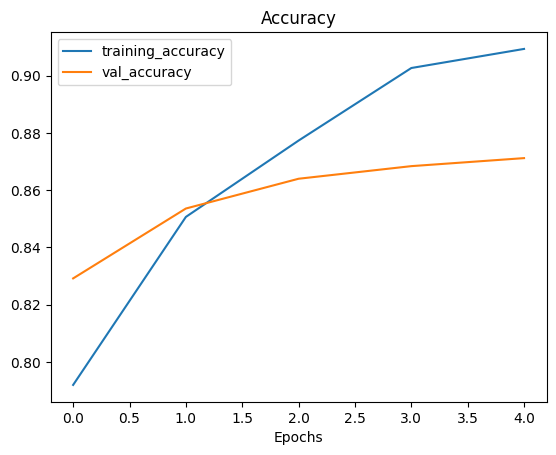

In [21]:
plot_loss_curves(efficientnet_history)

#Uploading experiments to TensorBoard
To upload a series of TensorFlow logs to TensorBoard, we can use the following command:

Upload TensorBoard dev records


!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot
Where:


--logdir is the target upload directory
--name is the name of the experiment
--description is a brief description of the experiment
--one_shot exits the TensorBoard uploader once uploading is finished
Running the tensorboard dev upload command will first ask you to authorize the upload to TensorBoard.dev. After you've authorized the upload, your log files will be uploaded.

#Deleting experiments from TensorBoard
tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]